# Van Bergen, Ma, Pratte, Jehee Baysian Decoder from: 
    
* Van Bergen, R. S., Ma, W.J., Pratte, M.S. & Jehee, J.F.M. (2015). Sensory uncertainty decoded from visual cortex predicts behavior. Nature Neuroscience.

* Tried to stick to conventions of Matlab code from Ruben Van Bergen (and tried to use similar variable names when possible)

* One important change: I made the code a bit more flexible in terms of the span of the basis functions to accomodate modeling features like orientation over 180deg and modeling features like spatial position over 360 degrees. 
    

In [1]:
%reload_ext autoreload
%autoreload 2

In [38]:
# import modules 
import numpy as np
import matplotlib.pyplot as plt
from DecodeSNC_CViter import DecodeSNC_CViter #NB: if error "No Modules named 'past'" must install 'future' eg. pip install future
import sys
sys.path.append(".")

### Dictionary object to store stim and analysis info for passing between functions. Stand in for Ruben's p structure.
* Set up with some defaults here, and can then populate with listed fields OR will populate in gen_test_data function when running in test mode

In [6]:
# "runNs" : xx, "test_trials" : xx, "stimfeat" : xx
p = {"nchans" : 8, "span" : 180, "ninit" : 20, "sig_guess" : 0.5, "tau_guess" : 0.7, "rho_guess" : 0.1}

### Now start a cross-val loop to train the model and decode test data - this is like the DecodeCV matlab function from Ruben

In [45]:
# load functions...
# %run -i "DecodeSNC_CViter.py"
# %run -i "fun_minLL_norm.py"
# %run -i "invSNC.py"
# %run -i "minimizeNLCG.py"
# %run -i "my_logdet.py"
# %run -i "EstimateSNC.py"
# %run -i "MatProdTrace.py"

In [7]:
from scipy.io import loadmat
dat = loadmat('dat_trySNC.mat') 

In [8]:
samples = dat['dat']['samples'][0,0]
runNs = np.concatenate(dat['dat'][0,0][1][0,0][0])
stimfeat = np.concatenate(dat['dat'][0,0][1][0,0][1])
p['samples'] = samples
p['runNs'] = runNs
p['stimfeat'] = stimfeat

In [42]:
# set up a few variables here for dealing with LOO-CV
runs = np.unique(p["runNs"])
est = np.full(p["runNs"].shape, np.nan)
unc = np.full(p["runNs"].shape, np.nan)

# list comprehension to make list of dictionaries to store output of 'EstimateSNC'
# Pest = [{"tau" : 0, "sig" : 0,"rho" : 0,"corr" : 0} for i in range(0,len(runs))]
Pest=[]
# note: access a given field in each dict in Pest with: [item["rho"] for item in Pest]

# note: default to start on first run, but if implement HPC then update this
start_idx = 0 # used internally by DecodeSNC

# loop and train/test
for testrun_idx in np.arange(start_idx,len(runs)):
    # Note: Ruben's code made a copy of 'p' and passed that. I'm just going to update the 
    # "test_trials" entry of p and pass it directly...
    
    # figure out the test trials on this fold - all trials except those that are 
    # from the current run
    p["test_trials"] = (p["runNs"]==runs[testrun_idx])

    # do iteration of the LOO-CV" decoding procedure
    OUT = DecodeSNC_CViter(p["samples"], p);  
    est[p["test_trials"]], unc[p["test_trials"]],out  = OUT
    Pest.append(out)
    print(testrun_idx,'Complete')

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:69: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:59: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:100: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/fun_minLL_norm.py:61: RuntimeWarning: invalid value encountered in sqrt
  der[nvox] = 2 * sig * MatProdTrace(W.T @ omi, W) - np.sum(np.sum(np.power((U.T * float(np.sqrt(2*sig)) @ W),2))) # TS: good


0 Complete
Failed: 1
1 Complete
2 Complete
3 Complete
4 Complete
5 Complete
6 Complete
Failed: 1
Failed: 2
7 Complete
8 Complete
9 Complete
10 Complete
11 Complete
12 Complete


In [33]:
OUT = DecodeSNC_CViter(p["samples"], p);  

/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:69: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'lu') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:59: RuntimeWarning: invalid value encountered in log
  ld = my_logdet(csr_matrix(np.eye(nchans)) + float(sig**2) * WtDiW, 'chol') + np.log(1 + rho*nvox*alpha) + nvox*np.log(1-rho) + 2*np.sum(np.log(tau))  # verified TS 5/27
/mnt/neurocube/home/tsheehan/py_code/IEM_SNC/invSNC.py:100: RuntimeWarning: invalid value encountered in log
  d = np.log(c) + np.sum(np.log(np.abs(diag_upper)), axis = 0)


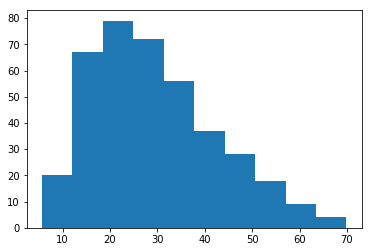

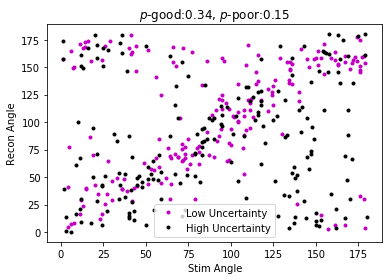

In [56]:
use = ~np.isnan(unc)
est_use = est[use]
unc_use = unc[use]
stimfeat_use = stimfeat[use]

plt.hist(unc_use)
plt.show()
good= unc_use<np.median(unc_use)
plt.plot(stimfeat_use[good],est_use[good],'m.')
plt.plot(stimfeat_use[~good],est_use[~good],'k.')

plt.xlabel('Stim Angle')
plt.ylabel('Recon Angle')
plt.legend(('Low Uncertainty','High Uncertainty'))
cc_good=np.corrcoef(stimfeat_use[good],est_use[good])[1,0]
cc_poor=np.corrcoef(stimfeat_use[~good],est_use[~good])[1,0]
plt.title('$p$-good:%.2f, $p$-poor:%.2f' %(cc_good,cc_poor))
plt.show()

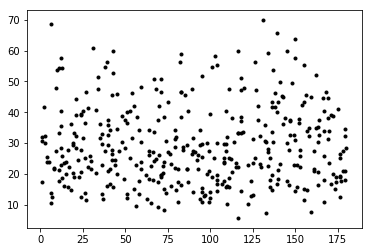

In [58]:
plt.plot(stimfeat,unc,'k.')